In [1]:
import pathlib
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import signal, interpolate, stats
import matplotlib.pyplot as plt

In [2]:
paths = list(pathlib.Path(".").glob("irm_*.xlsx"))

In [3]:
def load_irm(file):
    frame = pd.read_excel(file)
    frame["Time"] = pd.to_datetime(frame["Time"]).dt.floor("1T")
    frame = frame.set_index("Time").resample("1T").interpolate().reset_index()
    frame = frame.assign(file=file)
    frame["site"] = frame["file"].astype(str).apply(lambda x: x.replace(".", "_").split("_")[1].capitalize())
    return frame

In [4]:
dfs = []
for file in paths:
    dfs.append(load_irm(file))
ref = pd.concat(dfs, axis=0)
ref = ref.drop(ref.filter(regex="Un").columns, axis=1)

In [5]:
ref = ref.pivot_table(index="Time", columns="site", values="Pressure")

In [6]:
def load_grafana(file):
    frame = pd.read_csv(file, parse_dates=["Time"])
    frame = frame.set_index("Time")
    return frame

In [7]:
ircel = load_grafana("HungaTonga_Irceline.csv")
bme280 = load_grafana("HungaTonga_BM280.csv")

In [8]:
h = 31 + 3*3.5 # Altitude + 3 étages
dp = h*(1.225*9.81)
dp

498.71587500000004

In [9]:
bme280 += dp/100

In [11]:
bme_1h = bme280.resample("1H").mean()
bme_1m = bme280.resample("1T").mean()

In [12]:
comp2 = pd.concat([ref, bme_1m["BME280"]], axis=1)
comp2.sample(5)

,Assesse,Centre,Watermael,Woluwe,BME280
Time,,,,,
2022-01-16 23:06:00,1035.2,1032.88,1030.266667,1030.50,1033.503825
2022-01-14 03:45:00,NaN,NaN,NaN,NaN,1039.387159
2022-01-14 18:11:00,NaN,NaN,NaN,NaN,1036.187159
2022-01-17 03:02:00,NaN,NaN,NaN,NaN,1035.153825
2022-01-16 00:34:00,1027.8,1025.70,1022.750000,1022.93,1026.087159


In [13]:
comp = pd.concat([ircel, bme_1h], axis=1).dropna(subset=["BME280"])
comp.sample(5)

,41R001,BME280
Time,,
2022-01-16 05:00:00,1022,1025.887159
2022-01-17 07:00:00,1032,1035.801922
2022-01-15 20:00:00,1023,1026.238270
2022-01-15 10:00:00,1027,1030.034381
2022-01-16 04:00:00,1022,1025.619471


In [14]:
credits = "Sources: IRM, BlueBox\nCredits: J. Landercy"
credits2 = "Sources: BlueBox\nCredits: J. Landercy"

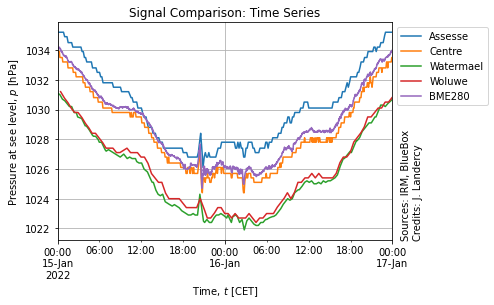

In [15]:
axe = comp2.loc["2022-01-15 00:00:00":"2022-01-17 00:00:00", :].plot()
axe.set_title("Signal Comparison: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure at see level, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits, rotation=90)
axe.legend(bbox_to_anchor=(1, 1))
axe.grid()

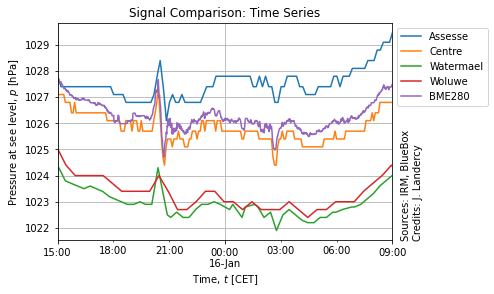

In [16]:
axe = comp2.loc["2022-01-15 15:00:00":"2022-01-16 09:00:00", :].plot()
axe.set_title("Signal Comparison: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure at see level, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits, rotation=90)
axe.legend(bbox_to_anchor=(1, 1))
axe.grid()

In [17]:
X = comp["41R001"].values.reshape(-1, 1)
y = comp["BME280"].values

In [18]:
reg = LinearRegression().fit(X, y)
score = reg.score(X, y)
score

0.9960983966777712

In [19]:
reg.coef_

array([0.99341705])

In [20]:
reg.intercept_

10.323994015956146

$\Delta p = \rho g h$

In [21]:
(reg.intercept_*100)/(1.225*9.81)

85.90978814584156

In [22]:
yhat = reg.predict(X)

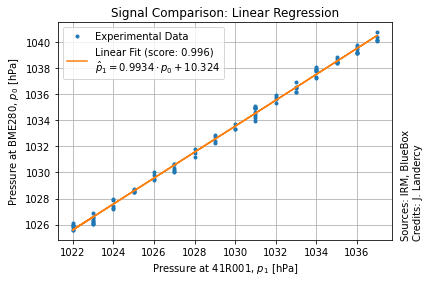

In [23]:
fig, axe = plt.subplots()
axe.plot(X, y, ".", label="Experimental Data")
axe.plot(X, yhat, label="Linear Fit (score: %.3f)\n$\hat{p}_1 = %.4f\cdot p_0 + %.3f$" % (score, reg.coef_[0], reg.intercept_))
axe.set_title("Signal Comparison: Linear Regression")
axe.set_xlabel("Pressure at 41R001, $p_1$ [hPa]")
axe.set_ylabel("Pressure at BME280, $p_0$ [hPa]")
axe.figure.text(0.92, 0.13, credits, rotation=90)
axe.legend()
axe.grid()

In [24]:
bme280

,BME280
Time,
2022-01-14 00:00:00,1040.987159
2022-01-14 00:00:10,1040.987159
2022-01-14 00:00:20,1040.987159
2022-01-14 00:00:30,1040.987159
2022-01-14 00:00:40,1040.987159
...,...
2022-01-17 23:59:10,1040.187159
2022-01-17 23:59:20,1040.187159
2022-01-17 23:59:30,1040.187159


In [25]:
bme280["Interpolated"] = bme280["BME280"].interpolate()
bme280["Baseline"] = signal.savgol_filter(bme280["Interpolated"].values, 181, 7)
bme280["Error"] = bme280["Interpolated"] - bme280["Baseline"]

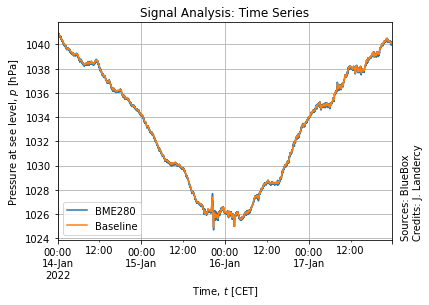

In [52]:
axe = bme280.loc[:,["BME280", "Baseline"]].plot()
axe.set_title("Signal Analysis: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure at see level, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits2, rotation=90)
axe.grid()

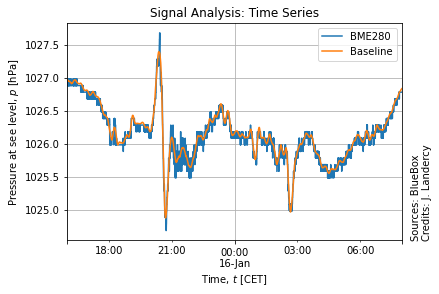

In [35]:
axe = bme280.loc["2022-01-15 16:00:00":"2022-01-16 08:00:00",["BME280", "Baseline"]].plot()
axe.set_title("Signal Analysis: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure at see level, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits2, rotation=90)
axe.grid()

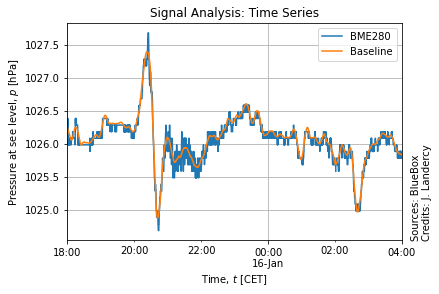

In [36]:
axe = bme280.loc["2022-01-15 18:00:00":"2022-01-16 04:00:00",["BME280", "Baseline"]].plot()
axe.set_title("Signal Analysis: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure at see level, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits2, rotation=90)
axe.grid()

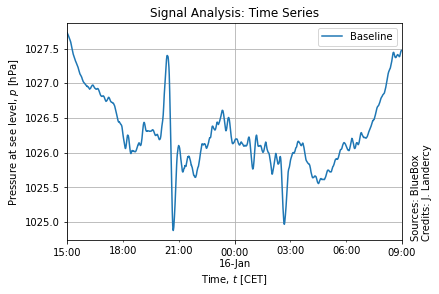

In [38]:
axe = bme280.loc["2022-01-15 15:00:00":"2022-01-16 09:00:00",["Baseline"]].plot()
axe.set_title("Signal Analysis: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure at see level, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits2, rotation=90)
axe.grid()

In [48]:
t0 = pd.Timestamp("2022-01-15T04:14:45+00:00")
t1 = pd.Timestamp("2022-01-15T19:00:00+00:00")

In [50]:
d = 16705

In [49]:
((t1-t0).total_seconds()*343)/1000.

18218.445

In [30]:
sel = bme280.loc["2022-01-15 18:00:00":"2022-01-16 04:00:00",["Error"]]

In [31]:
norm_p = stats.norm.fit(sel.values)
norm = stats.norm(*norm_p)
elin = np.linspace(-0.4, 0.4, 1001)

In [32]:
cauchy_p = stats.cauchy.fit(sel.values)
cauchy = stats.cauchy(*cauchy_p)

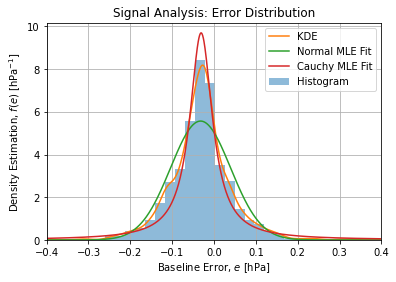

In [33]:
axe = sel.plot(kind="hist", bins=30, density=1, alpha=0.5)
sel.plot(kind="kde", ax=axe)
axe.plot(elin, norm.pdf(elin))
axe.plot(elin, cauchy.pdf(elin))
axe.set_xlim([elin.min(), elin.max()])
axe.set_title("Signal Analysis: Error Distribution")
axe.set_xlabel("Baseline Error, $e$ [hPa]")
axe.set_ylabel("Density Estimation, $f(e)$ $[\mathrm{hPa}^{-1}]$")
axe.legend(["KDE", "Normal MLE Fit", "Cauchy MLE Fit", "Histogram"])
axe.grid()